# TRGAN: Bank transaction conditional generation.

### Kirill Zakharov

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

from TRGAN.TRGAN_main import *
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan_train
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *

plt.style.use('ggplot')

### Import data

In [2]:
data = pd.read_csv('Data/czech.csv')

In [3]:
data.head()

,Unnamed: 0,column_a,account_id,date,type,operation,amount,balance,k_symbol,age,tcode
0,0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,29,cash_cr
1,1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,29,bank_cr
2,2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,29,cash_cr
3,3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,29,interest_cr
4,4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,29,bank_cr


In [4]:
data.shape

(1056320, 11)

### Filter data for train

In [5]:
data_test = copy.deepcopy(data)

In [6]:
from datetime import datetime
czech_date_parser = lambda x: datetime.strptime(str(x), "%y%m%d")

In [7]:
data["datetime"] = data["date"].apply(czech_date_parser)

In [8]:
data = data.rename(columns={"account_id": 'customer', 'tcode': 'mcc', 'datetime': 'transaction_date'})

data = data.drop(['date', 'Unnamed: 0', 'type', 'operation', 'k_symbol', 'balance', 'age', 'column_a'], axis=1)

# data = data.iloc[np.where(((data['amount'] >= 0.1) & (data['amount'] <= 9_000)))[0]]

idx_customer = (data['customer'].value_counts().loc[(data['customer'].value_counts() > 20) == True]).index.tolist()
data = data[data['customer'].isin(idx_customer)]

# idx_mcc = (data['mcc'].value_counts().loc[(data['mcc'].value_counts() > 50) == True]).index.tolist()
# data = data[data['mcc'].isin(idx_mcc)]

In [9]:
data.shape

(1056018, 4)

In [10]:
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data = data.sort_values(by='transaction_date')
data = data.reset_index(drop=True)

In [11]:
# customer_transaction = data.groupby('customer').indices
# transactions_array = []
# customer_array = []

# for key, val in customer_transaction.items():
#     transactions_array.append(val)
#     customer_array.append(key)
# idx_train = np.random.permutation(np.arange(len(customer_array)))
# idx_train = idx_train[:int(len(idx_train)*0.8)]
# idx_test = np.setdiff1d(np.arange(len(customer_array)), idx_train)
# train = data.loc[np.hstack(np.array(transactions_array)[idx_train])].sort_values(by='transaction_date')
# test = data.loc[np.hstack(np.array(transactions_array)[idx_test])].sort_values(by='transaction_date')
# test

In [12]:
# data.to_csv('Data/transactions_raif_exp4.csv', index=False)

In [13]:
# data = pd.read_csv('Data/data_raif_preprocessed.csv')
# datetime = pd.to_datetime(data['transaction_date'])
# data['transaction_date'] = datetime
# data = data.sort_values(by='transaction_date')
# data = data.reset_index(drop=True)

In [14]:
# data = pd.read_csv('Data/transactions_raif_exp4.csv')
# datetime = pd.to_datetime(data['transaction_date'])
# data['transaction_date'] = datetime
# data = data.sort_values(by='transaction_date')

In [15]:
data.head()

,customer,amount,mcc,transaction_date
0,576,900.0,cash_cr,1993-01-01
1,704,1000.0,cash_cr,1993-01-01
2,2378,700.0,cash_cr,1993-01-01
3,3818,600.0,cash_cr,1993-01-01
4,1972,400.0,cash_cr,1993-01-02


In [16]:
le = LabelEncoder()
data['mcc'] = le.fit_transform(data['mcc'])

In [17]:
data.shape

(1056018, 4)

In [18]:
synth_banksformer = pd.read_csv('Data/czech_synth_banksformer_full.csv')
synth_banksformer['date'] = pd.to_datetime(synth_banksformer['date'])

synth_banksformer = synth_banksformer.rename(columns={'tcode': 'mcc', 'date': 'transaction_date', 'account_id': 'customer'})
synth_banksformer['mcc'] = le.fit_transform(synth_banksformer['mcc'])

deltas_by_clients_banksformer = synth_banksformer.groupby('customer')['transaction_date'].apply(lambda x: (x - x.shift()).dt.days.values[1:])

### Initialize all constants

In [19]:
'''
FEATURES NAMES
'''
cat_features = ['mcc']
cont_features = ['amount']
date_feature = ['transaction_date']
client_info = ['customer']

# data_cat = data[cat_features] 

'''
DIMENSIONS
'''
dim_X_cat = len(cat_features)
dim_X_cont = len(cont_features)
dim_X_date = 4
dim_Xoh = 20 # dimension of X one hot embeddings
dim_Xcl = 4  # dimension of client's info embeddings
dim_Vc_h = 6 # dimension of conditional vector
dim_bce = 5 # dimension of the behaviour client encoding
dim_Vc = dim_Vc_h + dim_X_date
dim_X_emb = dim_Xoh + dim_X_cont + dim_Xcl
dim_noise = 5
# data_dim = len(data_transformed[0])

'''
LEARNING RATES
'''
lr_E_oh = 3e-4
lr_E_cl = 1e-3
lr_E_Vc = 1e-3

'''
SAVE DIRECTORY
'''
DIRECTORY = 'Pretrained_model/'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Create OneHot representation of all categorical features $X_{oh}$ of dimension $d_{X_{oh}}$

In [20]:
experiment_id = 'czech_3'
load = True

In [21]:
X_oh = onehot_emb_categorical(data, cat_features)

### Create embeddings of the $X_{oh}$

In [22]:
X_oh_emb, encoder_onehot, decoder_onehot = trgan_train.create_cat_emb(X_oh,dim_Xoh, lr_E_oh, epochs=15, batch_size=2**9, load=load,\
                directory=DIRECTORY, names=[f'TRGAN_E_oh_exp_{experiment_id}.pkl', f'TRGAN_D_oh_exp_{experiment_id}.pkl', f'X_oh_emb_exp_{experiment_id}.npy'])

### Create embeddings of the $X_{cont}$

In [23]:
X_cont, scaler_cont = preprocessing_cont(data, cont_features, type_scale='CBNormalize')

### Create embeddings of the $X_{cl}$

In [24]:
X_cl, encoder_cl_emb, decoder_cl_emb, scaler_cl_emb, label_encoders = trgan_train.create_client_emb(dim_Xcl, data, client_info, dim_Xcl, lr_E_cl, epochs=15, batch_size=2**9,\
            load=load, directory=DIRECTORY, names=[f'TRGAN_E_cl_{experiment_id}.pkl',\
                     f'TRGAN_D_cl_{experiment_id}.pkl', f'X_cl_{experiment_id}.npy', f'scaler_{experiment_id}.joblib', f'label_enc_{experiment_id}.joblib'])

In [25]:
X_emb, scaler_emb = create_embeddings(X_cont, X_oh_emb, X_cl)

### Create conditional vector $v$

In [26]:
cond_vector, synth_time, date_transformations, behaviour_cl_enc, encoder, deltas_by_clients, synth_deltas_by_clients =\
            trgan_train.create_conditional_vector(data, X_emb, date_feature, 'initial', dim_Vc_h, dim_bce, \
            name_client_id='customer', name_agg_feature='amount', lr_E_Vc=lr_E_Vc, epochs=15, batch_size=2**9, model_time='poisson', n_splits=2, load=load,\
            directory=DIRECTORY, names=[f'TRGAN_E_Vc_{experiment_id}.pkl', f'Vc_{experiment_id}.npy', f'BCE_{experiment_id}.npy'])

In [27]:
print(f'Dim X_emb: {X_emb.shape} || Dim V_c: {cond_vector.shape}')

Dim X_emb: (1056018, 25) || Dim V_c: (1056018, 10)


In [32]:
real_deltas = np.hstack(deltas_by_clients.values)
synth_pois_deltas = np.hstack(synth_deltas_by_clients)
synth_deltas_banksformer = np.hstack(deltas_by_clients_banksformer)

real_deltas = real_deltas[np.where(real_deltas < np.quantile(real_deltas, 0.997))[0]].astype(int)
synth_pois_deltas = synth_pois_deltas[np.where(synth_pois_deltas < np.quantile(synth_pois_deltas, 0.999))[0]].astype(int)
synth_deltas_banksformer = synth_deltas_banksformer[np.where(synth_deltas_banksformer < np.quantile(synth_deltas_banksformer, 0.999))[0]].astype(int)

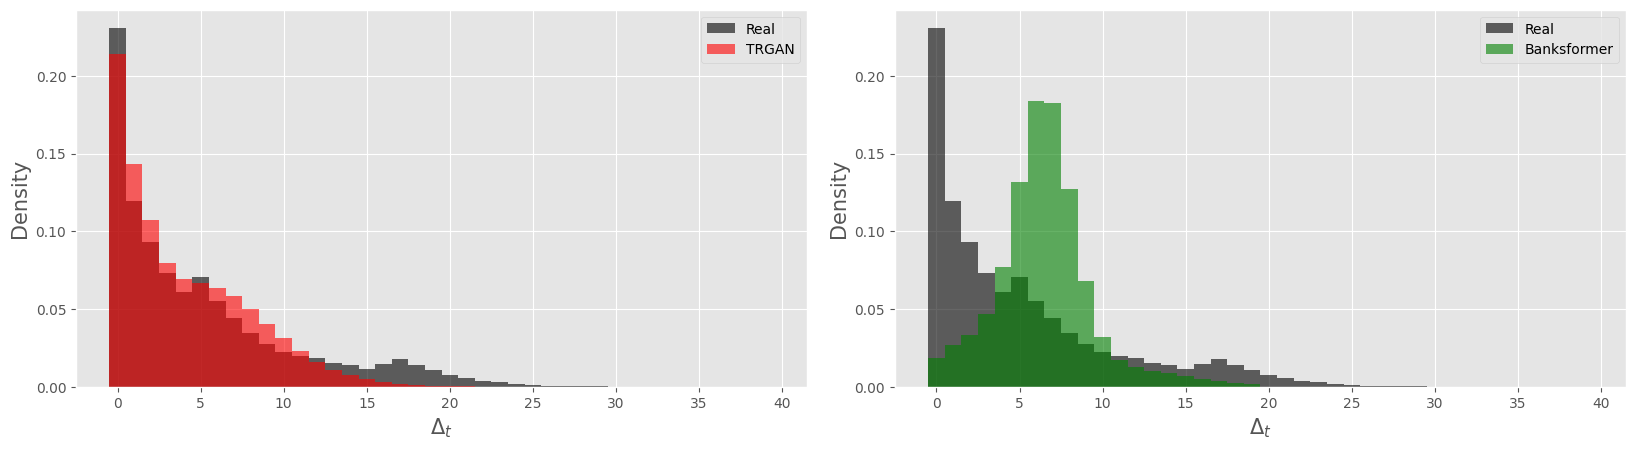

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

axs[0].hist(real_deltas, alpha=0.6, bins=np.arange(-1, 40) + 0.5, label='Real', density=True, color='black')
axs[0].hist(synth_pois_deltas, alpha=0.6, bins=np.arange(-1, 40) + 0.5, label='TRGAN', density=True, color='red')

axs[0].legend()
axs[0].set_xlabel('$\Delta_t$', fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].locator_params(axis='x', integer=True)

axs[1].hist(real_deltas, alpha=0.6, bins=np.arange(-1, 40) + 0.5, label='Real', density=True, color='black')
axs[1].hist(synth_deltas_banksformer, alpha=0.6, bins=np.arange(-1, 40) + 0.5, label='Banksformer', density=True, color='green')

axs[1].legend()
axs[1].set_xlabel('$\Delta_t$', fontsize=15)
axs[1].set_ylabel('Density', fontsize=15)
axs[1].locator_params(axis='x', integer=True)

# plt.savefig('synth_deltas_czech.pdf', dpi=300)
plt.subplots_adjust(wspace=0.12)
plt.show()

### Train TRGAN

In [28]:
# load = False

In [28]:
h_dim = 2**6
num_blocks_gen = 1
num_blocks_dis = 1

if load:
    generator = Generator(dim_noise + dim_Vc, dim_X_emb, h_dim, num_blocks_gen).to(DEVICE)
    supervisor = Supervisor(dim_X_emb + dim_Vc, dim_X_emb, h_dim, num_blocks_gen).to(DEVICE)

    generator.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl'))
    supervisor.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl'))

    generator.eval()
    supervisor.eval()

    loss_array = np.load(f'{DIRECTORY}loss_array_exp_{experiment_id}.npy')

else:
    generator, supervisor, loss_array, discriminator, discriminator2 = train_generator(X_emb, cond_vector, dim_Vc, dim_X_emb, dim_noise, batch_size=2**10,\
                                                    lr_rates=[8e-4, 8e-4, 8e-4, 8e-4], num_epochs=20, num_blocks_gen=num_blocks_gen, num_blocks_dis=num_blocks_dis, h_dim=h_dim)
    
    torch.save(generator.state_dict(), f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl')
    torch.save(supervisor.state_dict(), f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl')

    np.save(f'{DIRECTORY}loss_array_exp_{experiment_id}.npy', loss_array)

    generator.eval()
    supervisor.eval()

### Loss functions

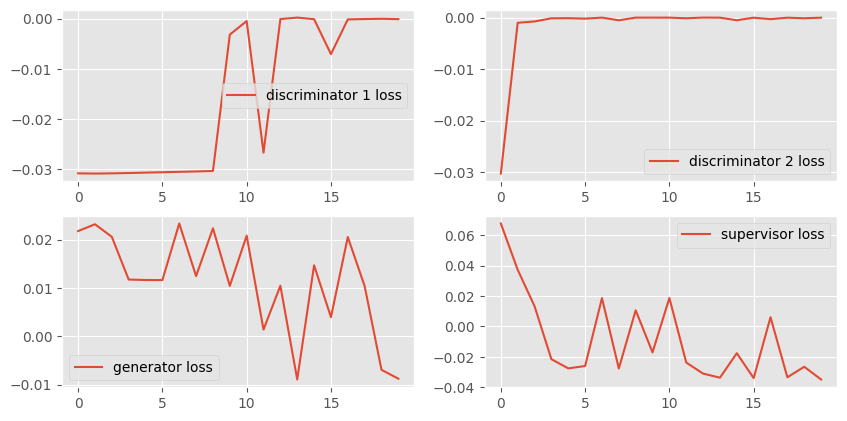

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].plot(np.array(loss_array).T[0], label='discriminator 1 loss')
axs[0, 1].plot(np.array(loss_array).T[1], label='discriminator 2 loss')
axs[1, 0].plot(np.array(loss_array).T[2], label='generator loss')
axs[1, 1].plot(np.array(loss_array).T[3], label='supervisor loss')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.show()

In [30]:
from pytorch_model_summary import summary

print(summary(generator, torch.zeros((512, dim_noise+dim_Vc)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [512, 15]           1,024           1,024
       LeakyReLU-2           [512, 64]               0               0
       LayerNorm-3           [512, 64]             128             128
          Linear-4           [512, 64]           2,080           2,080
       LeakyReLU-5           [512, 32]               0               0
          Linear-6           [512, 64]           2,080           2,080
          Linear-7           [512, 64]           2,080           2,080
          Linear-8           [512, 96]           6,208           6,208
       LayerNorm-9           [512, 64]             128             128
         Linear-10           [512, 64]           4,160           4,160
      LeakyReLU-11           [512, 64]               0               0
        Dropout-12           [512, 64]               0               0
     

In [31]:
# print(summary(discriminator, torch.zeros((512, dim_X_emb+dim_Vc)), show_input=True))

### Generate synthetics

In [32]:
n_samples = len(X_emb[:])
synth_data, synth_time = sample(n_samples, generator, supervisor, dim_noise, cond_vector,\
                                X_emb, encoder, data, behaviour_cl_enc, date_feature, 'customer', time='initial', model_time='normal')

In [33]:
synth_df, synth_df_cat = inverse_transforms(n_samples, synth_data, synth_time, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                    label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize')

In [34]:
synth_df = synth_df.sort_values(by='transaction_date')
# synth_df['mcc'] = le.inverse_transform(synth_df['mcc'])
# data['mcc'] = le.inverse_transform(data['mcc'])
synth_df

,customer,amount,transaction_date,mcc
0,1107,858.1,1993-01-01,6
1,2902,939.3,1993-01-01,6
2,3551,708.3,1993-01-01,6
3,8519,647.8,1993-01-01,6
4,4437,399.9,1993-01-02,6
...,...,...,...,...
1053014,2891,153.1,1998-12-31,13
1053013,4588,102.5,1998-12-31,13
1053012,855,282.1,1998-12-31,13
1053018,10656,89.5,1998-12-31,13


## Quality Assessment

In [63]:
X_gr = []
X_gr.append(X_emb[:, :21].T[:7])
X_gr.append(X_emb[:, :21].T[7:14])
X_gr.append(X_emb[:, :21].T[14:21])
X_gr = np.array(X_gr)

X_gr_s = []
X_gr_s.append(synth_data[:, :21].T[:7])
X_gr_s.append(synth_data[:, :21].T[7:14])
X_gr_s.append(synth_data[:, :21].T[14:21])
X_gr_s = np.array(X_gr_s)

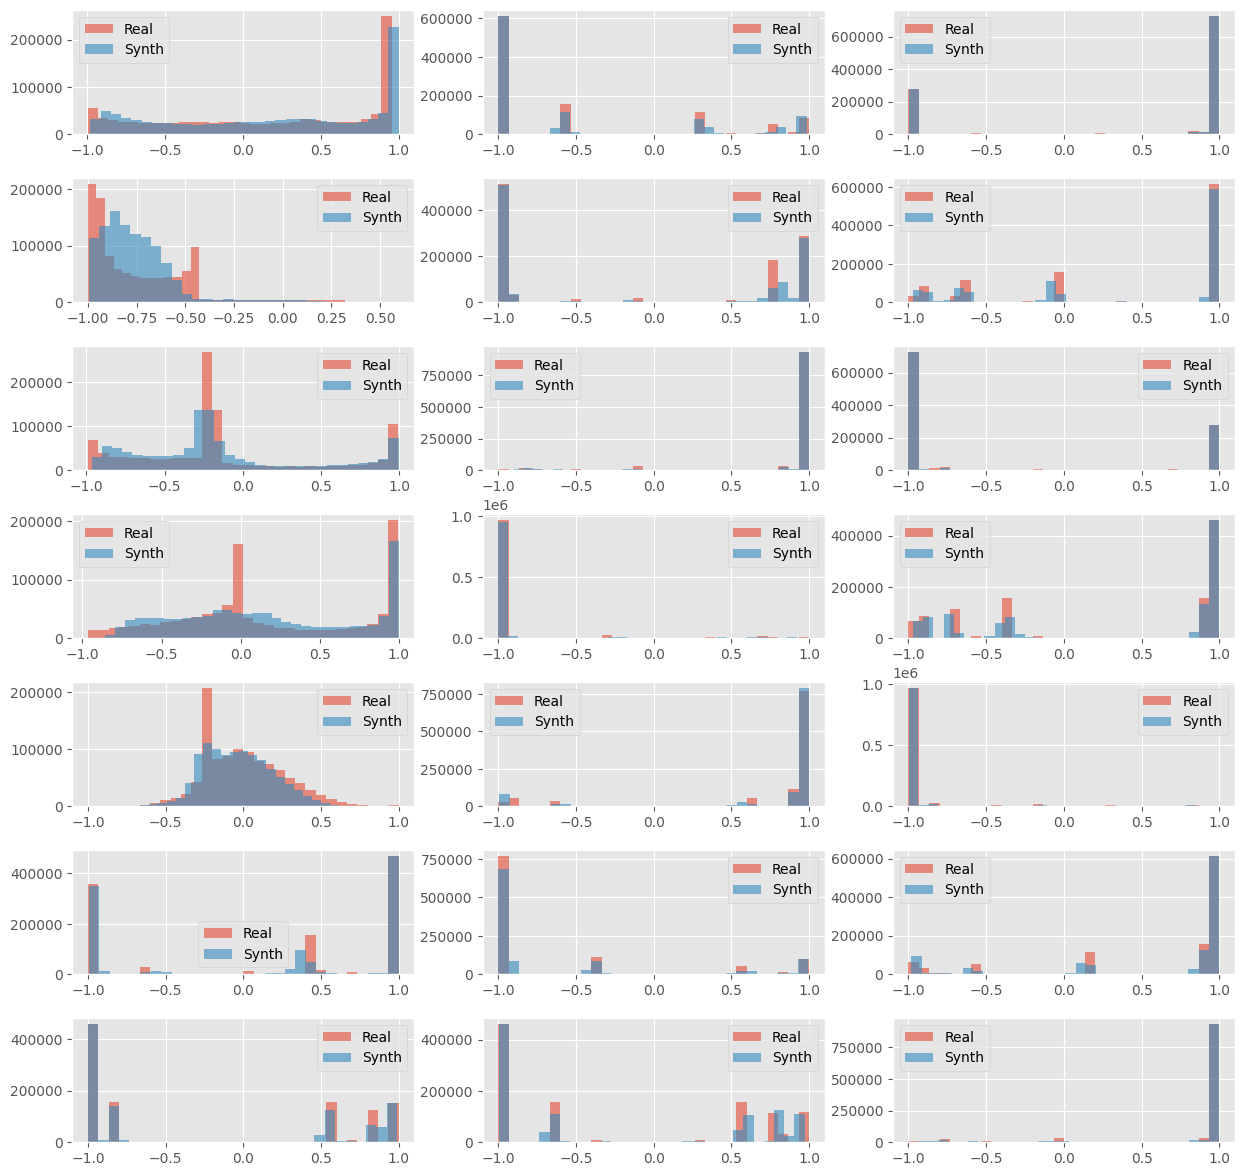

In [64]:
fig, axs = plt.subplots(7, 3, figsize=(15, 15), dpi=100)

for i in range(7):
    for j in range(3):
        axs[i, j].hist(X_gr[j, i], bins=30, label='Real', alpha=0.6)
        axs[i, j].hist(X_gr_s[j, i], bins=30, label='Synth', alpha=0.6)

        axs[i, j].legend()

plt.subplots_adjust(hspace=0.35)
# plt.savefig('results_synth_exp4.png', dpi=300)
plt.show()

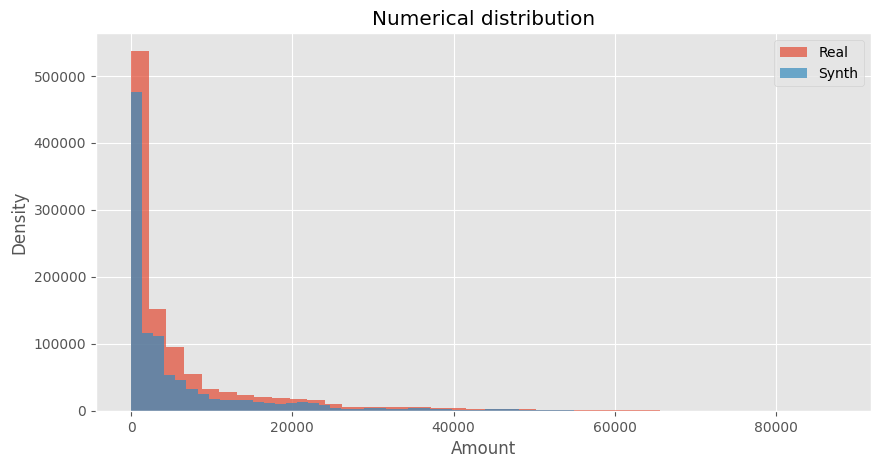

In [65]:
plt.subplots(figsize=(10, 5), dpi=100)

data['amount'].hist(bins=40, label='Real', alpha=0.7)
synth_df['amount'].hist(bins=40, label='Synth', alpha=0.7)

plt.legend()
plt.title('Numerical distribution')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.show()

### Compare mcc

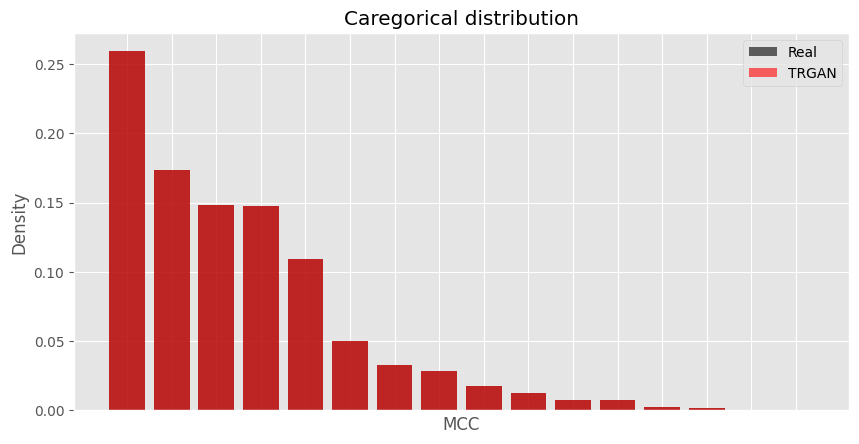

In [66]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.bar(np.sort(data['mcc'].value_counts().index.values).astype(str), data['mcc'].value_counts().values/(np.sum(data['mcc'].value_counts().values)),\
                                                    color='black', alpha=0.6, label='Real')
plt.bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str), synth_df['mcc'].value_counts().values/(np.sum(synth_df['mcc'].value_counts().values)),\
                                                    color='red', alpha=0.6, label='TRGAN')

# plt.xticks(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.legend()
plt.title('Caregorical distribution')
plt.ylabel('Density')
plt.xlabel('MCC')
plt.show()

In [47]:
metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')


metadata.add_column(
    column_name='customer',
    sdtype='categorical')


metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

In [48]:
from sdmetrics.single_table import NewRowSynthesis

NewRowSynthesis.compute(
    # real_data=data.drop('index', axis=1),
    real_data=data,
    synthetic_data=synth_df,
    metadata=metadata,
    numerical_match_tolerance=0.4,
    synthetic_sample_size=10_000
)

0.4282

In [49]:
evaluate_categorical(data_array=[data['mcc'], synth_df['mcc']], index=['Real', 'TRGAN'], data_cont_array=[data[['mcc', 'transaction_date']], synth_df[['mcc', 'transaction_date']]])

,Total Variation,Contingency Similarity,Values count
Real,1.000000,1.00000,16.0
TRGAN,0.999526,0.40599,16.0


### Compare clients' features

In [50]:
# fig, axs = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

# axs[0].hist(data['customer'], alpha=0.7, label='Real', bins=40)
# axs[0].hist(synth_df['customer'], alpha=0.7, label='Synth', bins=40)

# axs[0].legend()
# axs[0].set_xticks(np.arange(0, len(data['customer'].value_counts()), 500), np.arange(0, len(data['customer'].value_counts()), 500))
# axs[0].set_title('Client id')

# axs[1].hist(data['terminal'], alpha=0.7, label='Real', bins=40)
# axs[1].hist(synth_df['terminal'], alpha=0.7, label='Synth', bins=40)

# axs[1].legend()
# axs[1].set_xticks(np.arange(0, len(synth_df['terminal'].value_counts()), 300), np.arange(0, len(synth_df['terminal'].value_counts()), 300))
# axs[1].set_title('Terminal id')
# plt.show()

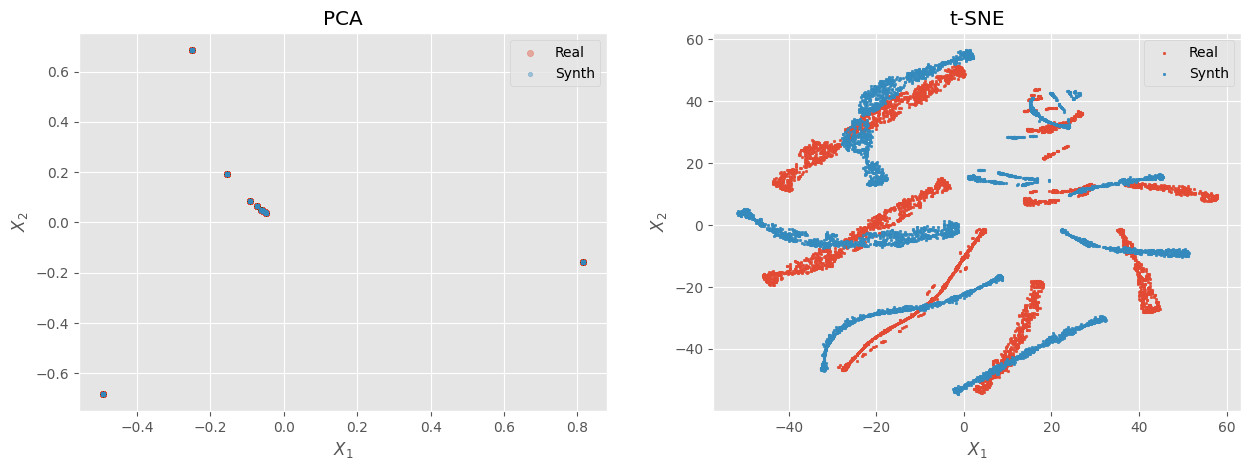

In [189]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca1 = PCA(n_components=2)
# pca2 = PCA(n_components=2)

data_transformed_pca = pca1.fit_transform(X_oh)
synth_pca = pca1.transform(synth_df_cat)
# data_transformed_pca = pca1.fit_transform(X_emb)
# synth_pca = pca2.fit_transform(synth_data)

tsne1 = TSNE(n_components=2, perplexity = 80)
tsne2 = TSNE(n_components=2, perplexity = 80)

idx_random = np.random.randint(0, len(X_emb), 5000)

data_transformed_tsne = tsne1.fit_transform(X_emb[idx_random])
synth_tsne = tsne2.fit_transform(synth_data[idx_random])


figure, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

axs[0].scatter(data_transformed_pca.T[0], data_transformed_pca.T[1], label='Real', alpha=0.4, s=20)
axs[0].scatter(synth_pca.T[0], synth_pca.T[1], label='Synth', alpha=0.4, s=10)

axs[0].legend()
axs[0].set_xlabel('$X_1$')
axs[0].set_ylabel('$X_2$')
axs[0].set_title('PCA')


axs[1].scatter(data_transformed_tsne.T[0], data_transformed_tsne.T[1], label='Real', s=3, alpha=1)
axs[1].scatter(synth_tsne.T[0], synth_tsne.T[1], label='Synth', s=3, alpha=1)

axs[1].legend()
axs[1].set_xlabel('$X_1$')
axs[1].set_ylabel('$X_2$')
axs[1].set_title('t-SNE')

plt.show()

## Comparison with other models

Prepare metadata for methods

In [35]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')

metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

Choose categorical columns for metrics calculation

In [36]:
cat_columns = ['mcc']

### Compare categorical columns

In [37]:
def copulagan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):
    
    if load:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load(f'{DIRECTORY}CopulaGAN.pkl')
    else:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save(f'{DIRECTORY}CopulaGAN.pkl')

    synth_copulagan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_copulagan = pd.get_dummies(synth_copulagan[cat_columns], columns=cat_columns)

    return synth_copulagan, synth_df_cat_copulagan

def ctgan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):

    if load:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load(f'{DIRECTORY}CTGAN.pkl')
    else:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save(f'{DIRECTORY}CTGAN.pkl')
 
    synth_ctgan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_ctgan = pd.get_dummies(synth_ctgan[cat_columns], columns=cat_columns)

    return synth_ctgan, synth_df_cat_ctgan

def compare_categorical_w_banksformer(data, synth_df, synth_df_cat, X_oh, metadata, cat_columns, synth_banks,\
                                    epochs=2, n_samples=10_000, comp_col='mcc', contig_cols=['mcc', 'customer'], load=False):
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

    axs[0, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 0].bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str),\
            synth_df['mcc'].value_counts().values/np.sum(synth_df['mcc'].value_counts().values), color='red', alpha=0.6, label='TRGAN')
    
    # axs[0, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('Category', fontsize=15)
    axs[0, 0].set_ylabel('Density', fontsize=15)
#     axs[0, 0].set_title('TRGAN')


    axs[0, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 1].bar(np.sort(synth_ctgan['mcc'].value_counts().index.values).astype(str),\
            synth_ctgan['mcc'].value_counts().values/np.sum(synth_ctgan['mcc'].value_counts().values), color='lightblue', alpha=0.6, label='CTGAN')

    # axs[0, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[0, 1].legend()
    axs[0, 1].set_xlabel('Category', fontsize=15)
    axs[0, 1].set_ylabel('Density', fontsize=15)
#     axs[0, 1].set_title('CTGAN')


    axs[1, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[1, 0].bar(np.sort(synth_copulagan['mcc'].value_counts().index.values).astype(str),\
            synth_copulagan['mcc'].value_counts().values/np.sum(synth_copulagan['mcc'].value_counts().values), color='orange', alpha=0.6, label='CopulaGAN')

    # axs[1, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('Category', fontsize=15)
    axs[1, 0].set_ylabel('Density', fontsize=15)
#     axs[1, 0].set_title('CopulaGAN')

    
    axs[1, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[1, 1].bar(np.sort(synth_banksformer['mcc'].value_counts().index.values).astype(str),\
            synth_banksformer['mcc'].value_counts().values/np.sum(synth_banksformer['mcc'].value_counts().values), color='green', alpha=0.6, label='Banksformer')
    
    # axs[1, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Category', fontsize=15)
    axs[1, 1].set_ylabel('Density', fontsize=15)
#     axs[1, 1].set_title('Banksformer')

    plt.subplots_adjust(hspace=0.15, wspace=0.12)
    # plt.savefig('synth_mcc_czech.pdf', dpi=300)
    # plt.savefig('synth_mcc_czech.png', dpi=300)
    plt.show()

#     display(evaluate_new_rows([data, synth_df, synth_ctgan, synth_copulagan, synth_banksformer],\
                # index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'], metadata=metadata))

    eval_cat = evaluate_categorical([data[comp_col], synth_df[comp_col], synth_ctgan[comp_col], synth_copulagan[comp_col], synth_banksformer[comp_col]],\
                                     index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'],\
    data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_ctgan[contig_cols], synth_copulagan[contig_cols], synth_banksformer[contig_cols]])

    return eval_cat

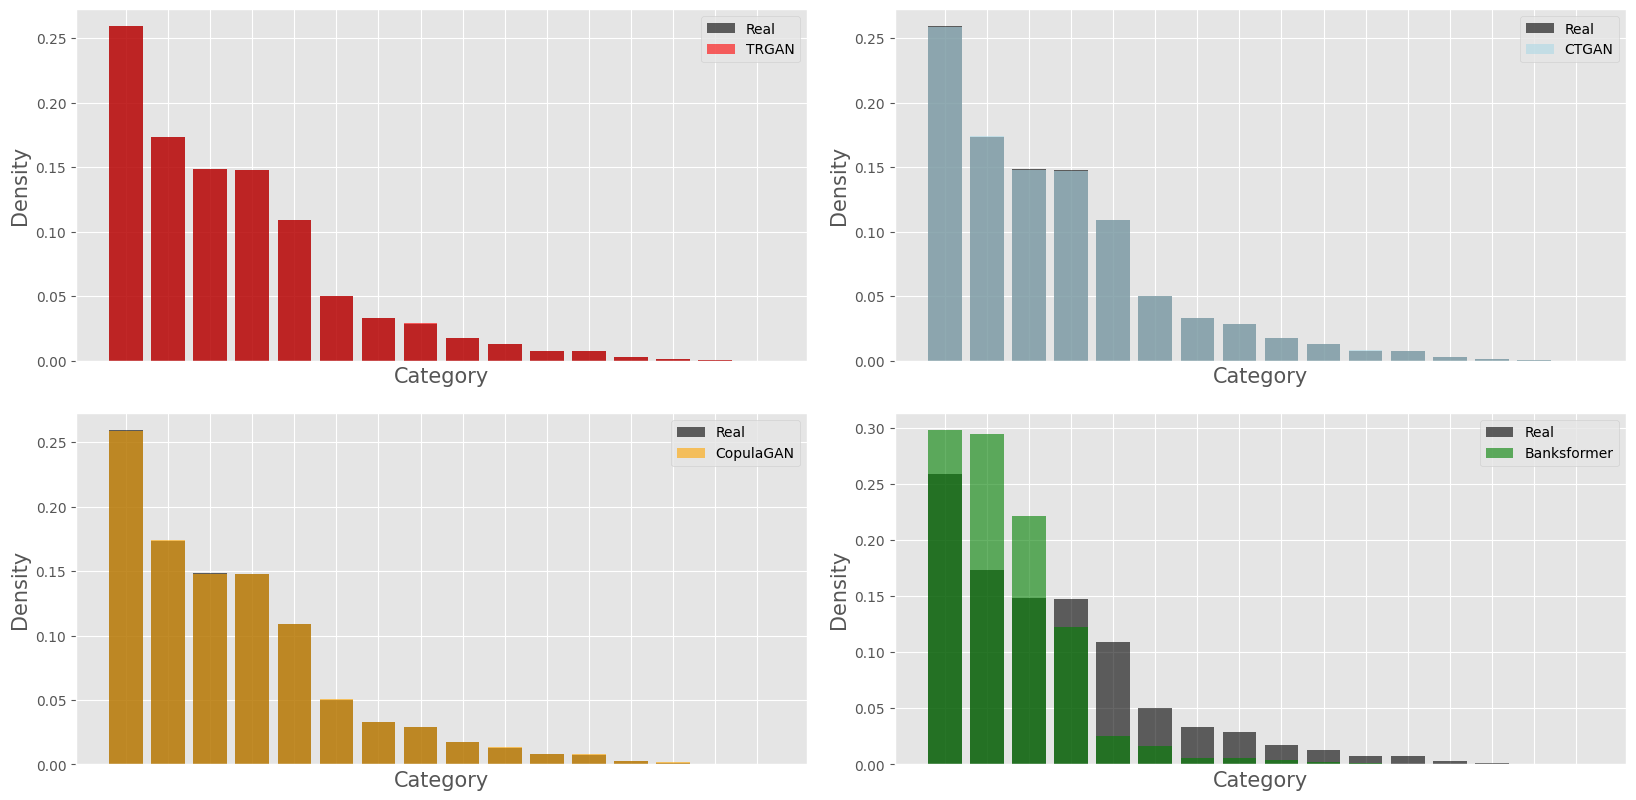

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,16.0,0.000000
TRGAN,0.999757,0.999755,16.0,0.195930
CTGAN,0.998471,0.384207,16.0,0.288252
CopulaGAN,0.998268,0.386815,16.0,0.288261
Banksformer,0.766253,0.128037,16.0,0.245042


In [70]:
compare_categorical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df[['mcc', 'amount', 'transaction_date']], synth_df_cat, X_oh, metadata, \
            cat_columns, synth_banksformer.sample(len(data))[['mcc', 'amount', 'transaction_date']],\
            epochs=5, n_samples=len(data), comp_col='mcc', contig_cols=['mcc', 'transaction_date'], load=True)

### Compare numerical columns

In [43]:
def compare_numerical_w_banksformer(data, synth_df, metadata, cat_columns, synth_banks, epochs=10, n_samples=10_000,\
                                    comp_col='amount', load=False, type_comp='log_amount', data_customer=''):
    
    """_summary_

    Returns:
       Object: Return graphs and table with metrics

    Types of visuals:
        - Log amount: log_amount
        - Cash flow: cash_flow

    """
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    if type_comp == 'log_amount':

        hist_real = np.histogram(np.log1p(data[comp_col]), normed=True, bins=40)
        max_hist_x = 12

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(np.log1p(data[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(np.log1p(synth_df[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend()
        axs[0, 0].set_xlabel('Log amount', fontsize=15)
        axs[0, 0].set_ylabel('Density', fontsize=15)
        axs[0, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(np.log1p(data[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(np.log1p(synth_ctgan[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend()
        axs[0, 1].set_xlabel('Log amount', fontsize=15)
        axs[0, 1].set_ylabel('Density', fontsize=15)
        axs[0, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(np.log1p(data[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(np.log1p(synth_copulagan[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend()
        axs[1, 0].set_xlabel('Log amount', fontsize=15)
        axs[1, 0].set_ylabel('Density', fontsize=15)
        axs[1, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[1, 0].set_title('CopulaGAN')

        axs[1, 1].hist(np.log1p(data[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='Real', alpha=0.7, density=True, color='black')
        axs[1, 1].hist(np.log1p(synth_banksformer[comp_col]), bins=np.arange(0, max_hist_x, 0.2), label='Banksformer', alpha=0.7, density=True, color='green')
        axs[1, 1].legend()
        axs[1, 1].set_xlabel('Log amount', fontsize=15)
        axs[1, 1].set_ylabel('Density', fontsize=15)
        axs[1, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.15)
        # plt.savefig('synth_amount_czech.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical([np.log1p(data[comp_col]), np.log1p(synth_df[comp_col]), np.log1p(synth_ctgan[comp_col]),\
                                       np.log1p(synth_copulagan[comp_col]), np.log1p(synth_banksformer[comp_col])],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'])
        
        return eval_num
    
    elif type_comp == 'cash_flow':

        data = copy.deepcopy(data)
        data['month'] = data['transaction_date'].dt.month
        synth_banksformer['month'] = synth_banksformer['transaction_date'].dt.month
        synth_df['month'] = synth_df['transaction_date'].dt.month
        synth_ctgan['month'] = synth_ctgan['transaction_date'].dt.month
        synth_copulagan['month'] = synth_copulagan['transaction_date'].dt.month
        # synth_tvae['month'] = synth_tvae['transaction_date'].dt.month

        data = pd.concat([data, data_customer], axis=1)
        synth_ctgan = pd.concat([synth_ctgan, data_customer], axis=1)
        synth_copulagan = pd.concat([synth_copulagan, data_customer], axis=1)

        

        cash_flow_real = (data.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_banks = (synth_banksformer.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_trgan = (synth_df.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_ctgan = (synth_ctgan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_copulagan = (synth_copulagan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()

        q = np.quantile(cash_flow_real, 0.95)

        cash_flow_real = cash_flow_real.iloc[np.where((cash_flow_real <= q) & (cash_flow_real >= -q))[0]]
        cash_flow_banks = cash_flow_banks.iloc[np.where((cash_flow_banks <= q) & (cash_flow_banks >= -q))[0]]
        cash_flow_trgan = cash_flow_trgan.iloc[np.where((cash_flow_trgan <= q) & (cash_flow_trgan >= -q))[0]]
        cash_flow_ctgan = cash_flow_ctgan.iloc[np.where((cash_flow_ctgan <= q) & (cash_flow_ctgan >= -q))[0]]
        cash_flow_copulagan = cash_flow_copulagan.iloc[np.where((cash_flow_copulagan <= q) & (cash_flow_copulagan >= -q))[0]]
        
        min_length = np.min(list(map(lambda x: len(x), [cash_flow_real, cash_flow_trgan, cash_flow_banks, cash_flow_ctgan, cash_flow_copulagan])))

        cash_flow_real = pd.Series(random.sample(cash_flow_real.values.tolist(), min_length))
        cash_flow_banks = pd.Series(random.sample(cash_flow_banks.values.tolist(), min_length))
        cash_flow_trgan = pd.Series(random.sample(cash_flow_trgan.values.tolist(), min_length))
        cash_flow_ctgan = pd.Series(random.sample(cash_flow_ctgan.values.tolist(), min_length))
        cash_flow_copulagan = pd.Series(random.sample(cash_flow_copulagan.values.tolist(), min_length))

        hist_real = np.histogram(cash_flow_real, normed=True, bins=40)

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(cash_flow_trgan, bins=40, label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend()
        axs[0, 0].set_xlabel('Month cash flow', fontsize=15)
        axs[0, 0].set_ylabel('Density', fontsize=15)
        axs[0, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(cash_flow_ctgan, bins=40, label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend()
        axs[0, 1].set_xlabel('Month cash flow', fontsize=15)
        axs[0, 1].set_ylabel('Density', fontsize=15)
        axs[0, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(cash_flow_copulagan, bins=40, label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend()
        axs[1, 0].set_xlabel('Month cash flow', fontsize=15)
        axs[1, 0].set_ylabel('Density', fontsize=15)
        axs[1, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[1, 0].set_title('CopulaGAN')

        axs[1, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 1].hist(cash_flow_banks, bins=40, label='Banksformer', alpha=0.7, density=True, color='green')
        axs[1, 1].legend()
        axs[1, 1].set_xlabel('Month cash flow', fontsize=15)
        axs[1, 1].set_ylabel('Density', fontsize=15)
        axs[1, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.15)
        # plt.savefig('synth_cashflow_czech.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical_cashflow([cash_flow_real, cash_flow_trgan, cash_flow_ctgan, cash_flow_copulagan, cash_flow_banks],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'])
        
        return eval_num
    
    else:
        print('Choose the type of comparison')

<ipython-input-43-4c495b45f6bb>:21: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_real = np.histogram(np.log1p(data[comp_col]), normed=True, bins=40)


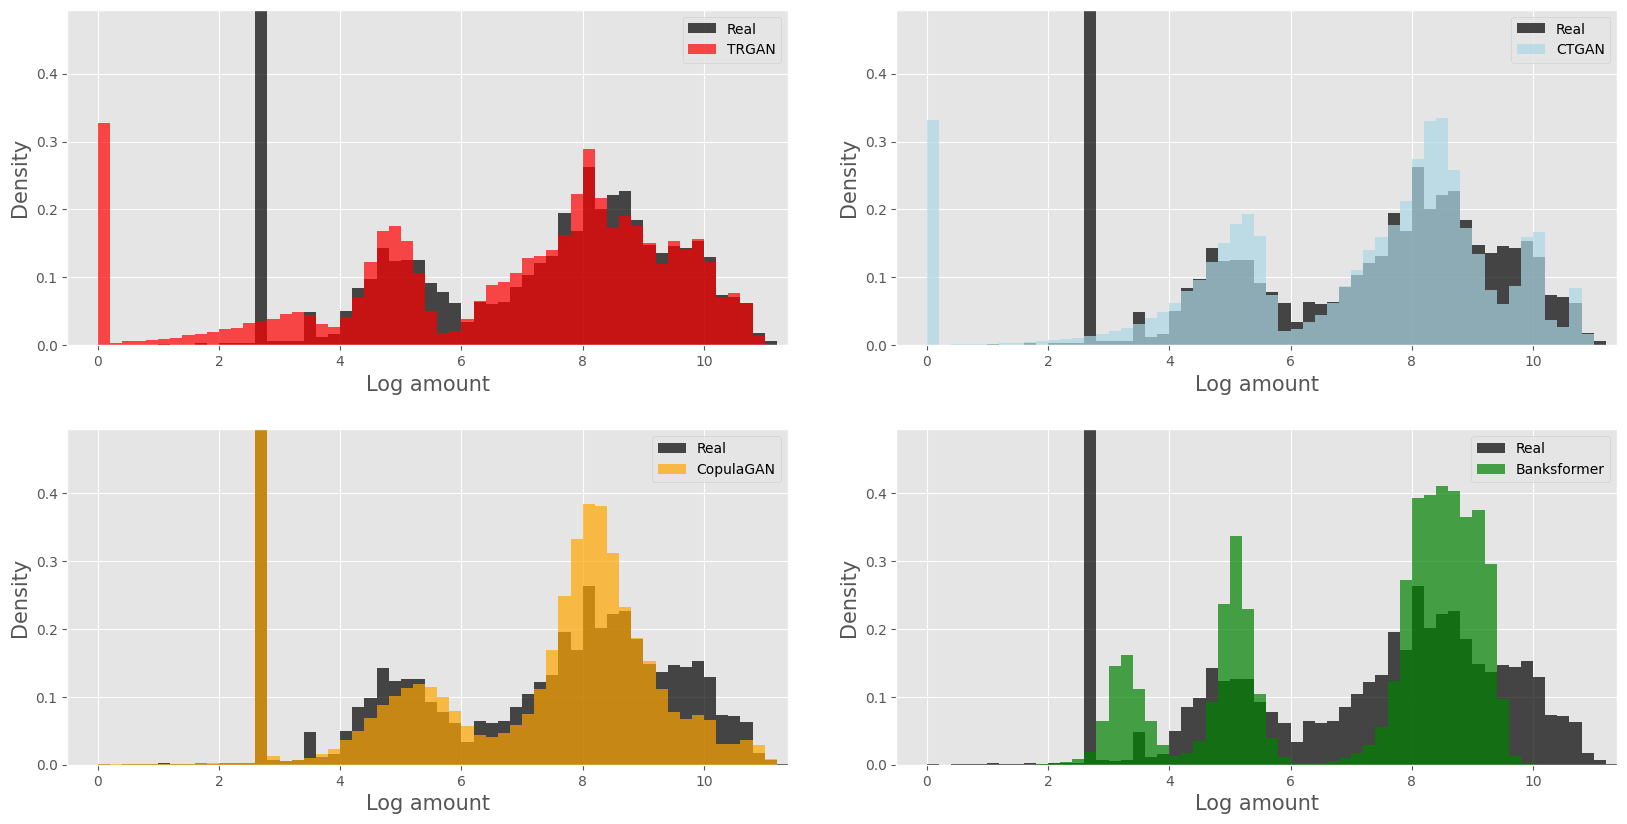

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,6.921501,2.446903,-1.028152,-0.437856,0.000000,0.000000,0.000000
TRGAN,6.714165,2.824514,-0.000800,-0.879701,0.096872,0.101726,0.283709
CTGAN,6.843934,2.655060,0.624658,-1.044707,0.098579,0.074330,0.414416
CopulaGAN,6.920901,2.274397,-0.693011,-0.653011,0.016412,0.092848,0.270552
Banksformer,7.128175,2.068865,-0.964002,-0.735366,0.035529,0.140490,0.507481


In [44]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df, metadata, cat_columns,\
                                synth_banksformer.sample(len(data)), epochs=5, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='log_amount', data_customer=data[['customer']])

<ipython-input-38-690d53e55ffd>:109: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_real = np.histogram(cash_flow_real, normed=True, bins=40)


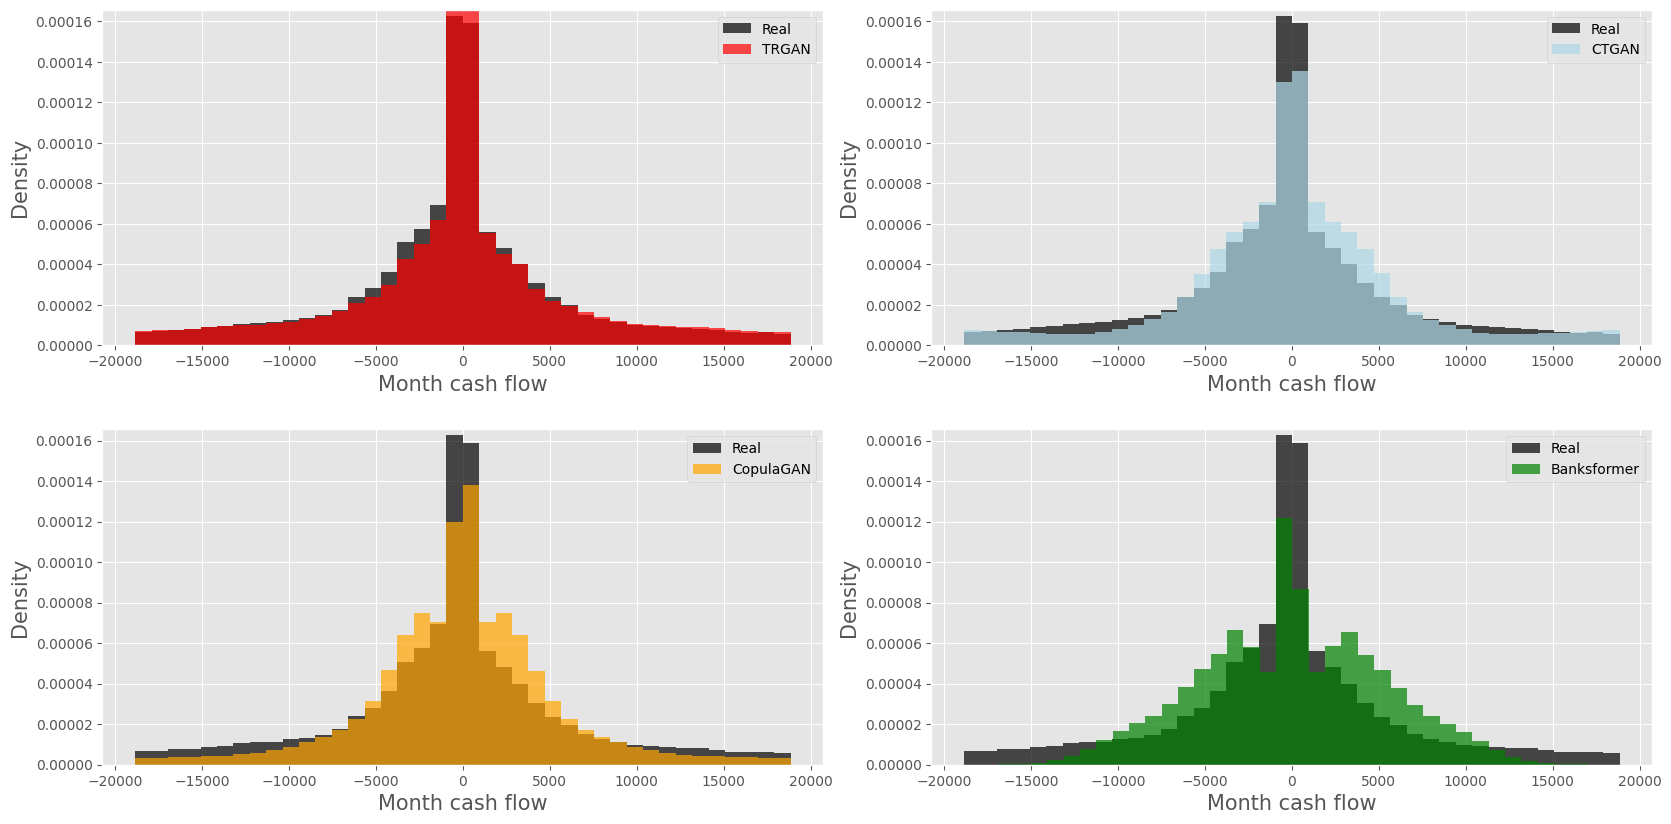

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,-395.065972,6434.569386,1.227576,0.013686,0.000000,0.000000,0.000000
TRGAN,-172.354992,6511.940276,1.243542,-0.004735,0.027617,0.051722,235.888486
CTGAN,-3.664942,6106.129703,1.757273,-0.004164,0.051093,0.066769,542.678227
CopulaGAN,-3.884617,5425.317541,1.872527,-0.003070,0.068560,0.072319,864.841564
Banksformer,-1.537369,5290.075763,-0.252298,0.000435,0.122123,0.098015,1240.247174


In [39]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df, metadata, cat_columns,\
                                synth_banksformer.sample(len(data)), epochs=5, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='cash_flow', data_customer=data[['customer']])

In [117]:
def compare_categorical_w_banksformer_3grams(data, synth_df, synth_banks):

    synth_banksformer = synth_banks


    real_3grams_idx, real_3grams_count = calculate_3_grams(data.sort_values(by=['customer'])[['mcc', 'customer']])
    trgan_3grams_idx, trgan_3grams_count = calculate_3_grams_synth(synth_df.sort_values(by=['customer'])[['mcc', 'customer']], real_3grams_idx)
    banks_3grams_idx, banks_3grams_count = calculate_3_grams_synth(synth_banksformer.sort_values(by=['customer'])[['mcc', 'customer']], real_3grams_idx)

    all_comb = real_3grams_idx

    #  np.sort(np.unique(np.hstack([real_3grams_idx, trgan_3grams_idx, ctgan_3grams_idx, copulagan_3grams_idx, banks_3grams_idx])))
    
    real_3grams_idx = calculate_idx_3_grams(real_3grams_idx, all_comb)
    trgan_3grams_idx = calculate_idx_3_grams(trgan_3grams_idx, all_comb)
    banks_3grams_idx = calculate_idx_3_grams(banks_3grams_idx, all_comb)

    real_3grams_count = real_3grams_count/np.sum(real_3grams_count)
    trgan_3grams_count = trgan_3grams_count/np.sum(trgan_3grams_count)
    banks_3grams_count = banks_3grams_count/np.sum(banks_3grams_count)


    fig, axs = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

    axs[0].bar(real_3grams_idx, real_3grams_count, color='black', alpha=0.6, label='Real')
    axs[0].bar(trgan_3grams_idx, trgan_3grams_count, color='red', alpha=0.6, label='TRGAN')
    
    axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[0].legend()
    axs[0].set_xlabel('3-grams', fontsize=15)
    axs[0].set_ylabel('Density', fontsize=15)
    # axs[0].set_ylim((0, 0.17))
#     axs[0, 0].set_title('TRGAN')
    
    axs[1].bar(real_3grams_idx, real_3grams_count, color='black', alpha=0.6, label='Real')
    axs[1].bar(banks_3grams_idx, banks_3grams_count, color='green', alpha=0.6, label='Banksformer')

    axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[1].legend()
    axs[1].set_xlabel('3-grams', fontsize=15)
    axs[1].set_ylabel('Density', fontsize=15)
    # axs[1].set_ylim((0, 0.17))
#     axs[1, 1].set_title('Banksformer')

    plt.subplots_adjust(hspace=0.15, wspace=0.16)
    plt.savefig('synth_3grams_czech.pdf', dpi=300)
    plt.show()


    z1 = list(zip(trgan_3grams_idx, trgan_3grams_count))
    trgan_3grams_count2 = np.array(sorted(np.concatenate([z1, list(zip(np.setdiff1d(real_3grams_idx, trgan_3grams_idx),\
                                                np.zeros(len(np.setdiff1d(real_3grams_idx, trgan_3grams_idx)))))]), key=lambda x: x[0])).T[1]
    
    z2 = list(zip(banks_3grams_idx, banks_3grams_count))
    banks_3grams_count2 = np.array(sorted(np.concatenate([z2, list(zip(np.setdiff1d(real_3grams_idx, banks_3grams_idx),\
                                                np.zeros(len(np.setdiff1d(real_3grams_idx, banks_3grams_idx)))))]), key=lambda x: x[0])).T[1]

    display(pd.DataFrame(np.array([[jensenshannon(real_3grams_count, real_3grams_count), jensenshannon(real_3grams_count, trgan_3grams_count2),\
                                    jensenshannon(real_3grams_count, banks_3grams_count2)],\
                                   [wasserstein_distance(real_3grams_count, real_3grams_count), wasserstein_distance(real_3grams_count, trgan_3grams_count),\
                                    wasserstein_distance(real_3grams_count, banks_3grams_count)]]).T,\
                        columns=['D_JS', 'W_1'], index=['Real', 'TRGAN', 'Banksformer']))

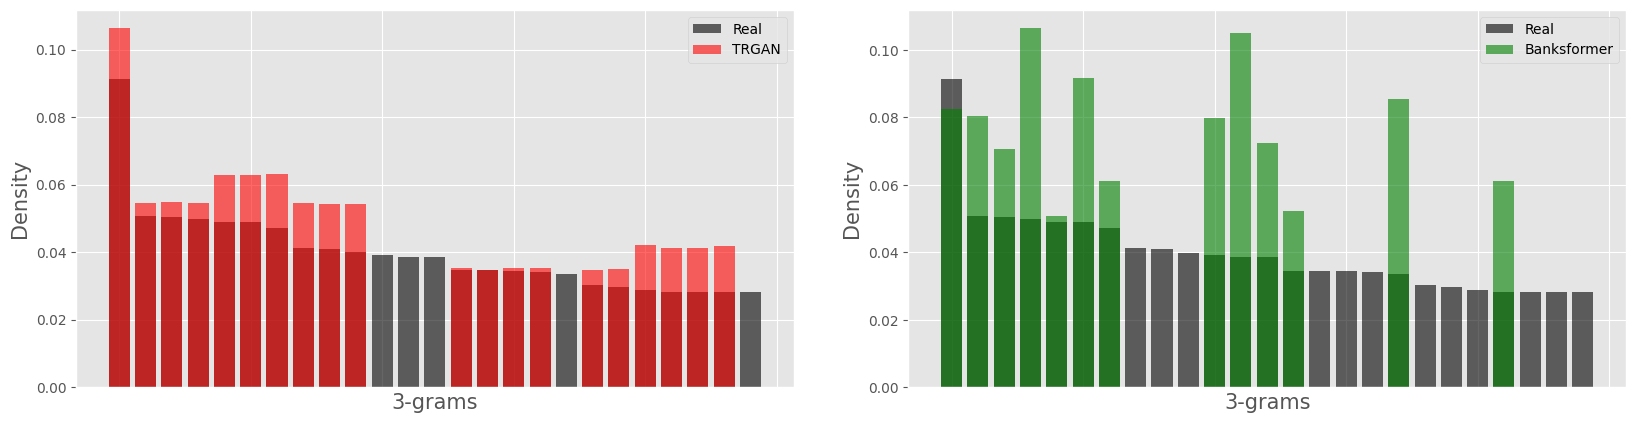

,D_JS,W_1
Real,0.000000,0.000000
TRGAN,0.260424,0.010000
Banksformer,0.417015,0.036923


In [118]:
compare_categorical_w_banksformer_3grams(data, synth_df, synth_banksformer)

In [ ]:
# synth_df.to_csv(f'Synthetic_data_{experiment_id}.csv', index=False)